<a href="https://colab.research.google.com/github/boneeyah/QTW/blob/main/Case%20Study%201/Case_Study_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install scikit-learn-intelex

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 9.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.9/13.9 MB 23.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 69.2/69.2 MB 6.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.0/4.0 MB 66.0 MB/s eta 0:00:00


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import Ridge
from sklearn.preprocessing import StandardScaler
from sklearn import metrics
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import KFold
from tabulate import tabulate
from sklearn.linear_model import ElasticNet
from sklearn.datasets import make_regression
from sklearn.model_selection import GridSearchCV
from numpy import arange
from sklearnex import patch_sklearn

In [3]:
df = pd.read_csv('https://raw.githubusercontent.com/KendallScott/QTW/main/Case%20Study%201/train.csv') 

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21263 entries, 0 to 21262
Data columns (total 82 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   number_of_elements               21263 non-null  int64  
 1   mean_atomic_mass                 21263 non-null  float64
 2   wtd_mean_atomic_mass             21263 non-null  float64
 3   gmean_atomic_mass                21263 non-null  float64
 4   wtd_gmean_atomic_mass            21263 non-null  float64
 5   entropy_atomic_mass              21263 non-null  float64
 6   wtd_entropy_atomic_mass          21263 non-null  float64
 7   range_atomic_mass                21263 non-null  float64
 8   wtd_range_atomic_mass            21263 non-null  float64
 9   std_atomic_mass                  21263 non-null  float64
 10  wtd_std_atomic_mass              21263 non-null  float64
 11  mean_fie                         21263 non-null  float64
 12  wtd_mean_fie      

In [5]:
unique = pd.read_csv('https://raw.githubusercontent.com/KendallScott/QTW/main/Case%20Study%201/unique_m.csv') 
unique = unique.loc[:, unique.columns != 'critical_temp']
unique = unique.loc[:, unique.columns != 'material']

df=df.join(unique)

In [6]:
#dropping correlated values reference: https://www.projectpro.io/recipes/drop-out-highly-correlated-features-in-python
corr_matrix = df.corr().abs()
corr_matrix

upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))

# find features with correlation greater than 0.95

to_drop = [column for column in upper.columns if any(upper[column] > 0.95)]

# drop highly correlated features

df.drop(to_drop, axis=1, inplace=True)

<ipython-input-6-7c1233e99907>:5: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))


In [7]:
# Make target and predictive datasets
y = df[['critical_temp']]
X = df.loc[:, df.columns != 'critical_temp']

In [8]:
Scaler = StandardScaler()
X_Scaled= Scaler.fit_transform(X)
X_Scaled = pd.DataFrame(X_Scaled, columns = X.columns)
y = pd.DataFrame(y)

In [9]:
# patch
patch_sklearn()
from sklearn.linear_model import ElasticNet
from sklearn.model_selection import GridSearchCV

# define grid
grid = dict()
grid['alpha'] = [0, 1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1.0, 10.0, 100.0]
grid['l1_ratio'] = arange(0, 1, 0.01)

#define the search
regr = ElasticNet(random_state=0)
cv = 5
search = GridSearchCV(regr, grid, scoring = 'neg_mean_absolute_error', cv=cv, n_jobs=-1)

#perform the search
results = search.fit(X_Scaled, y)
# summarize
print('MAE: %.3f' % results.best_score_)
print('Config: %s' % results.best_params_)

Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)


MAE: -14.251
Config: {'alpha': 0.1, 'l1_ratio': 0.74}


In [10]:
grid_results_table = pd.concat([pd.DataFrame(search.cv_results_["params"]),pd.DataFrame(search.cv_results_["mean_test_score"]*-1, columns=["MAE"])],axis=1)


In [11]:
grid_results_table

,alpha,l1_ratio,MAE
0,0.0,0.00,14.978901
1,0.0,0.01,14.978901
2,0.0,0.02,14.978901
3,0.0,0.03,14.978901
4,0.0,0.04,14.978901
...,...,...,...
895,100.0,0.95,32.866452
896,100.0,0.96,32.866452
897,100.0,0.97,32.866452
898,100.0,0.98,32.866452


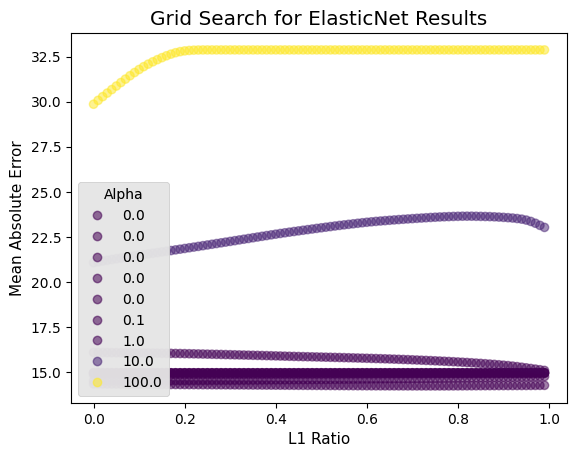

In [12]:
fig, ax = plt.subplots()
scatter=plt.scatter('l1_ratio', 'MAE', c='alpha', alpha=0.5, data=grid_results_table)
plt.style.use('ggplot')
plt.xlabel("L1 Ratio", size=11)
plt.ylabel("Mean Absolute Error", size=11)
plt.title('Grid Search for ElasticNet Results')

# produce a legend with the unique colors from the scatter
legend1 = ax.legend(*scatter.legend_elements(),
                    loc="lower left", title="Alpha")
ax.add_artist(legend1)

Results from the gridsearch CV showed Ridge was selected for regularization.

In [13]:
regr = ElasticNet(random_state=0, alpha=.1, l1_ratio= 0.74)

i=0

# Create a 10-fold cross-validation 
cv = KFold(n_splits = 10, 
           shuffle = True, 
           random_state = 42)

MAE = []

#i=0
for train, test in cv.split(X_Scaled, y):
    X_train, X_test = X_Scaled.iloc[train], X_Scaled.iloc[test]
    y_train, y_test = y.iloc[train], y.iloc[test]

    X_train, y_train = make_regression(n_features=2, random_state=0)
    
    regr.fit(X_Scaled, y)

    # Predict 
    y_pred_lin_reg = regr.predict(X_test)
  
    # Calculate  mean squared error
    lin_MAE_reg= metrics.mean_absolute_error(y_test, y_pred_lin_reg)

    i=i+1
    # Append to the list
    MAE.append(lin_MAE_reg)

    # Print the scores
    print(tabulate([[i, lin_MAE_reg, ]], 
               headers=['MAE']))

        MAE
--  -------
 1  12.8279
        MAE
--  -------
 2  12.4171
        MAE
--  -------
 3  13.5385
       MAE
--  ------
 4  12.955
        MAE
--  -------
 5  12.9521
        MAE
--  -------
 6  12.6641
        MAE
--  -------
 7  13.4323
        MAE
--  -------
 8  12.9171
        MAE
--  -------
 9  12.8899
        MAE
--  -------
10  13.1926


In [14]:
regr.n_features_in_

144

In [15]:
regr.feature_names_in_

array(['number_of_elements', 'mean_atomic_mass', 'wtd_mean_atomic_mass',
       'gmean_atomic_mass', 'entropy_atomic_mass',
       'wtd_entropy_atomic_mass', 'range_atomic_mass',
       'wtd_range_atomic_mass', 'wtd_std_atomic_mass', 'mean_fie',
       'wtd_mean_fie', 'wtd_entropy_fie', 'range_fie', 'wtd_range_fie',
       'wtd_std_fie', 'mean_atomic_radius', 'wtd_mean_atomic_radius',
       'gmean_atomic_radius', 'range_atomic_radius',
       'wtd_range_atomic_radius', 'mean_Density', 'wtd_mean_Density',
       'gmean_Density', 'entropy_Density', 'wtd_entropy_Density',
       'range_Density', 'wtd_range_Density', 'wtd_std_Density',
       'mean_ElectronAffinity', 'wtd_mean_ElectronAffinity',
       'gmean_ElectronAffinity', 'wtd_gmean_ElectronAffinity',
       'entropy_ElectronAffinity', 'wtd_entropy_ElectronAffinity',
       'range_ElectronAffinity', 'wtd_range_ElectronAffinity',
       'wtd_std_ElectronAffinity', 'mean_FusionHeat',
       'wtd_mean_FusionHeat', 'gmean_FusionHeat', '

In [16]:
regr.coef_

array([ 1.41781148e+00,  2.60488894e-01, -9.65623367e-01,  0.00000000e+00,
       -5.67706361e-01,  4.77970483e+00,  5.83362450e+00, -1.48476460e+00,
       -3.86835657e+00,  1.04278500e+00,  2.22876037e-01,  3.74851584e-01,
        2.46327272e-01,  0.00000000e+00,  0.00000000e+00, -5.62087598e-05,
        1.96422496e+00, -1.19020811e+00,  2.61905324e+00, -1.37622799e+00,
       -9.23668507e-01,  0.00000000e+00, -1.34521049e+00, -1.57397274e+00,
       -9.30794233e-01,  0.00000000e+00,  1.70759380e+00, -8.78173134e-01,
        1.35862055e+00,  5.03011316e-02,  0.00000000e+00, -3.35858917e+00,
       -1.14531125e+00, -3.20615236e+00,  0.00000000e+00, -9.85834416e-01,
        4.34077687e-02,  3.37223878e-01,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  2.96157002e+00, -6.87522507e-01,  8.21753635e-01,
       -1.37121914e+00,  2.01172469e+00,  9.18646732e+00, -1.97008262e+00,
       -7.69931122e+00,  9.83018192e-01,  1.40783874e+00,  1.59735013e+00,
        0.00000000e+00,  

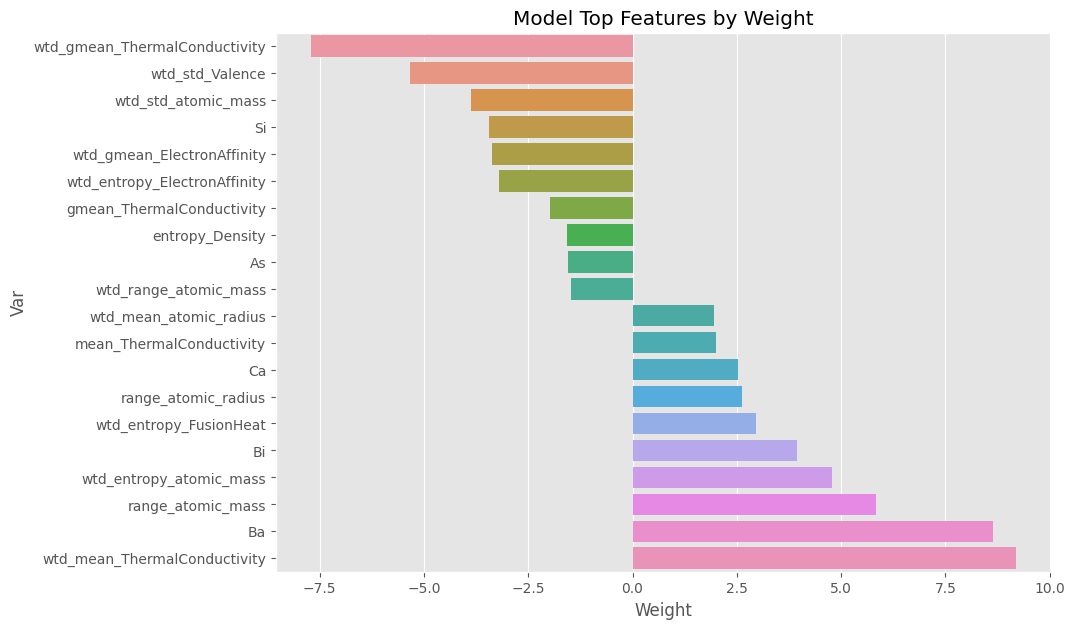

In [17]:
Weights = pd.Series(regr.coef_, index = regr.feature_names_in_)
Weights = pd.DataFrame({'Var':Weights.index, 'Weight':Weights.values})
Weights = Weights.sort_values('Weight')
Weights2 = pd.concat([Weights.head(10),Weights.tail(10)])
plt.figure(figsize=(10, 7))
sns.barplot(x='Weight', y = 'Var', data = Weights2,).set(title = "Model Top Features by Weight");

There were a number of variables included with a coefficient of 0.

In [18]:
#0 weight variables
Weights_drop = Weights[Weights["Weight"] == 0] 
Weights_drop

,Var,Weight
75,Ar,0.0
78,Sc,0.0
141,Po,0.0
109,Te,0.0
130,Ta,0.0
81,Cr,0.0
82,Mn,0.0
132,Re,0.0
131,W,0.0
111,Xe,0.0


Text(0, 0.5, 'Mean Absolute Error')

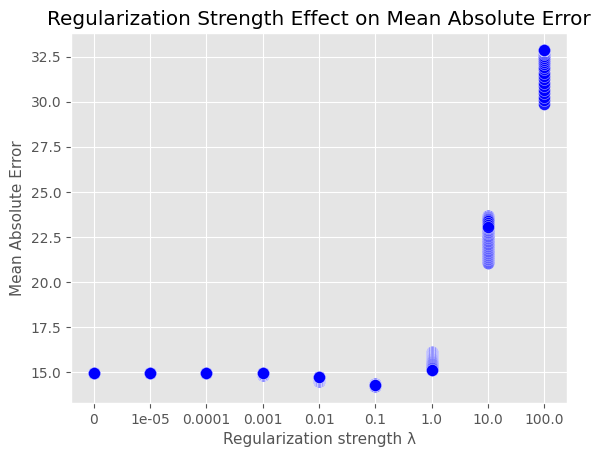

In [19]:
# Regularization strength error plot
score = pd.DataFrame(results.cv_results_)
plt.style.use('ggplot')
plt.scatter(x=score.param_alpha.astype('str'),
            y=score.mean_test_score*-1,
            c = 'blue',
            edgecolors='white',
            linewidths=.3,alpha=.9,
            s = 75)
plt.title('Regularization Strength Effect on Mean Absolute Error')
plt.xlabel('Regularization strength λ',fontsize = 11)

plt.ylabel('Mean Absolute Error',fontsize =11)

In [20]:
from sklearn.model_selection import KFold, cross_val_score
rng = np.random.default_rng(51323)
rseeds = rng.integers(low=0, high = 1000, size = 10)

mae_holder = []
alpha_holder = []
for k in rseeds:
  for j in [1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1.0, 10.0, 100.0]:
    regr = ElasticNet(random_state=k, alpha=j, l1_ratio= 0.74,max_iter=1500)

    i=0

    # Create a 10-fold cross-validation 
    cv = KFold(n_splits = 10, 
              shuffle = True, 
              random_state = k)

    MAE = []

    #i=0
    for train, test in cv.split(X_Scaled, y):
        X_train, X_test = X_Scaled.iloc[train], X_Scaled.iloc[test]
        y_train, y_test = y.iloc[train], y.iloc[test]

        X_train, y_train = make_regression(n_features=2, random_state=0)
        
        regr.fit(X_Scaled, y)

        # Predict 
        y_pred_lin_reg = regr.predict(X_test)
      
        # Calculate  mean squared error
        lin_MAE_reg= metrics.mean_absolute_error(y_test, y_pred_lin_reg)

        i=i+1
        # Append to the list
        mae_holder.append(lin_MAE_reg)
        alpha_holder.append(j)

Text(0, 0.5, 'Mean Absolute Error')

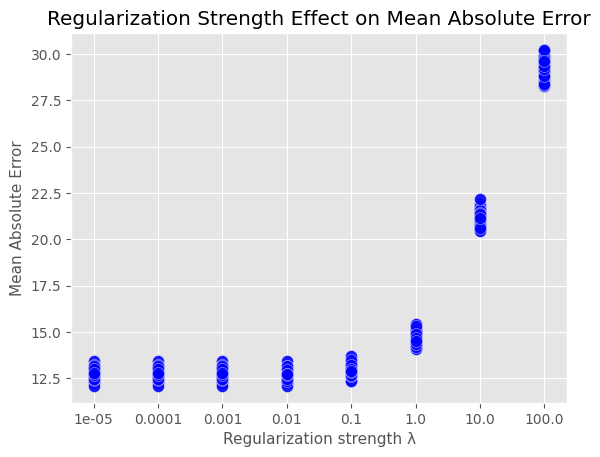

In [21]:
# Regularization strength error plot
score = pd.DataFrame(results.cv_results_)
plt.style.use('ggplot')
plt.scatter(x=list(map(str,alpha_holder)),
            y=mae_holder,
            c = 'blue',
            edgecolors='white',
            linewidths=.3,alpha=.9,
            s = 75)
plt.title('Regularization Strength Effect on Mean Absolute Error')
plt.xlabel('Regularization strength λ',fontsize = 11)

plt.ylabel('Mean Absolute Error',fontsize =11)